# **Image classification Exercise**
This code is written to classify images of airplanes, automobiles, birds, cats, deers, dogs, frogs, horses, ships, and trucks into the corresponding categories through a convolutional Neural Network (CNN)

# **Pre-Processing**

--------------------------------------------------------------------------------
**Imports & Functions**

In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

#IMPORTS
import numpy as np
from sklearn.model_selection import train_test_split
import os, sys

#Importing appropiate pakages depending on sys version
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle


#FUNCTIONS
#Opening & loading a file with different encoding depending on sys version
def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict

# Function to download cifar data
def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    
# Loading the data, bringing it in the right shape, and dividing it into 
# Train, Validation, and test data, as well as, Data and Labels
def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
#MORE IMPORTS
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#Print TensorFlow and Keras Versions
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


--------------------------------------------------------------------------------
Loading Data

In [3]:
# Load the data samples using previously defined load_cifar10() function
x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

# Defining numer of classes and class names
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

# Printing sample array dimensions
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


--------------------------------------------------------------------------------
Plotting some sample Images + Labels

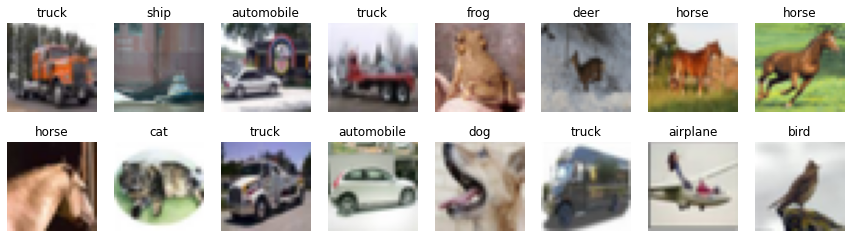

In [4]:
# show some random training imagesand their labels
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

--------------------------------------------------------------------------------
Import NN Data packages

In [6]:
# import necessary building blocks
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam, Adamax, SGD

# **Creating and Training CNN**

For the model I experimented with the following Parameters:

***Layer Weight Regulizers***
- **L2 regulization** at different alpha values. L2 Regulization adds a regularization term to the loss function, in order to avoid overfitting. I noticed that this decreases the testing network performance by about 8% when applied to all layers and 2% when applied to two out of nine layers, both at its default alpha value, and an alpha value of 0.005. Therfore, I decided not to include L2 regularization.
- **Dropout Layers** are "dropping out" some random nods during training, to avoid overfitting. 75% test accuracy without drop out layers, test 79% accuracy with dropout layers at 10% after every layer. Test Accuracy of 78% with dropout layers at 20%. Therfore, dropout layers at 10% are kept for all other runs.

***Network Structure/ Parameters***
- **Number of (Hidden) Layers**
    - 3 Hidden Layers = 74.93% Test accuracy
    - 5 Hidden Layers = 76.89 Test accuracy
    - 8 Hidden Layers = 77.00% Test accuracy
- **Different amount of Neurons + Types of Layers**

  The Network architecture can have a segnificant impact on its performance. It is important to chose a network size that is sufficiently large to solve the problem one is looking for, but not so large that it gets unproportionally computationally expensive. Each Layer in a network has a type, and an amount of neurons that belong to this layer. Especially for image classification, convolutional layers are very effective tools, as they are useful for pattern recognition. Dense layers are still required to make sense of the input/ output. There is no one solution for how to build a neural network, but it is mostly trail and error.

    **d = dense, c = Conv2D**

    These are all with MaxPooling layers in between. Without Max pooling layers the test accuracy decreases by about9%
    - Low to High 
    
    a) (16d - 32c - 32c - 64c - 64c - 128c - 128c - 256c - 256c - 10d) = Test accuracy 76.26%

    b) (32d - 32c - 32c - 64c - 64c - 128c - 128c - 256c - 256c - 10d) = Test accuracy 76.10%

    - Low to High to Low 
    
    a) (16d - 32c - 64c - 128c - 256c - 512c - 256c - 128c - 64c - 10d)
    =Test accuracy 76.32%
   
    b) (32d - 32c - 64c - 128c - 256c - 512c - 256c - 128c - 64c - 32c - 10d) =Test accuracy 77.31%
    - Alternating 
    
    a) (32d - 64c - 32c - 64c - 128c - 64c - 128c - 64c- 128c - 64c - 10d) = Test Accuracy 76.77%

    - High to low
    
    a) (128d - 256c - 256c - 128c - 128c - 64c - 64c - 32c - 32c - 10d) = Test Accuracy 79.73%

    b) (256d - 256c - 256c - 128c - 128c - 64c - 64c - 32c - 32c - 10d) = Test Accuracy 76.3%

    c)(128d - 256c - 512c - 512c- 256c - 256c - 128c - 128c - 64c - 64c - 32c - 32c - 10d) = Test Accuracy 78.12%

    --> From all networks, high to low a) performed best

- **Activation Function**
    
    Activation functions, are mathematical functions that determine the output of a layer/ network. They can be used to for example conduct binary classification etc. As they have a fundamental effect on the output of the network, they are an important variable to consider when trying to optimize a Neural Network.
    
    Last layer always softmax, first one always relu
    - RELU all except last layer = Test accuracy 79.12%
    - LEAKY RELU except first & last layer = 77.90%
    - ELU all except first & last layer = Test accuracy 78.61%

In [7]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))


    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    ### END STUDENT CODE ### 

    # Ensure normalized probabilities over the 10 classes

    return model

For the Training of the Model I experimented with the following Parameters

***Optimizer/ Initial Learningrate***

Optimizers are the different algorithems with which the loss function is minimized. One of the simplest ones is the gradient descent which is taking a fixed stepsize in the direction of steepest descent from each concurrent point. Some more advanced optimizers - like adam - adapt their stepsize dynamically, and are hence less likely to remain in a local minimum.
- **Adam** 77.8% test Accuracy
- **Adamax** 77.8% test Accuracy
- **SGD** 64.36% test Accuracy
--> Adam is used for all subsequent trainings

***Epochs***
- **Amount of Epochs** usually I was using 60 epochs to archive all accuracies so far, but from the accuracies displayed after each epoch, it seems that the final accuracy is archived earlier, so I will implement the early stopping mechanism to reduce training time.
- **Early Stopping** when trying for the first time, I put a patience of 2 and the training stopped after epoch 12. The testing accuracy was at 73%, so nearly 5% worse than after 60 epochs.

  Putting the patience at 5 epochs, the training ends at 15 epochs and the test accuracy comes out at 74.35%.
  
  Putting the pacience at 10 epochs, the test accuracy is 77.16% and the training stops at epoch 18. 

  Puttingg the patience at 15 epochs, the test accuracy actually decreased to 76.23%

  --> Early stopping will be kept at a patience of 10 epochs

***Batchsize***
- **512**  = Test Accuracy of 76.74%
- **256** = Test Accuracy of 77.21
- **128** = Test Accuracy of 77.2%
- **64** = Test Accuracy of 76.48
--> Batch size of 256 is kept

In [13]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 256
EPOCHS = 60


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)


model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=Adam(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)] #FOR EARLY STOPPING AFTER 10 Epochs

# fit model
history = model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=my_callbacks
)

# save weights to file to avoid re-training 78.21
model.save_weights("weights.h5")

Epoch 1/60
157/157 [==============================] - 40s 246ms/step - loss: 1.9668 - accuracy: 0.2914 - val_loss: 3.7520 - val_accuracy: 0.1351
Epoch 2/60
157/157 [==============================] - 37s 236ms/step - loss: 1.3164 - accuracy: 0.5176 - val_loss: 3.5500 - val_accuracy: 0.1523
Epoch 3/60
157/157 [==============================] - 38s 239ms/step - loss: 1.0660 - accuracy: 0.6203 - val_loss: 2.3749 - val_accuracy: 0.3050
Epoch 4/60
157/157 [==============================] - 38s 239ms/step - loss: 0.8726 - accuracy: 0.6932 - val_loss: 1.6897 - val_accuracy: 0.5566
Epoch 5/60
157/157 [==============================] - 37s 238ms/step - loss: 0.7475 - accuracy: 0.7379 - val_loss: 1.3371 - val_accuracy: 0.5877
Epoch 6/60
157/157 [==============================] - 37s 239ms/step - loss: 0.6311 - accuracy: 0.7826 - val_loss: 0.7900 - val_accuracy: 0.7386
Epoch 7/60
157/157 [==============================] - 37s 238ms/step - loss: 0.5697 - accuracy: 0.8025 - val_loss: 0.7434 - val_ac

# **Testing CNN**

In [14]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


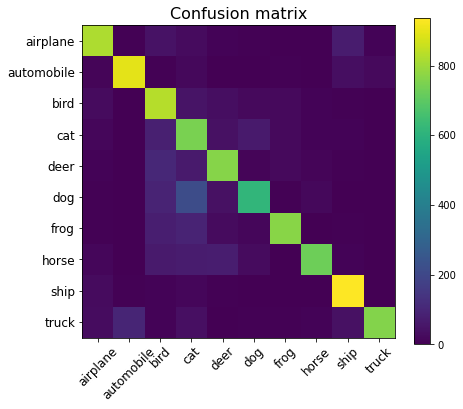

Test accuracy: 0.7871


In [15]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

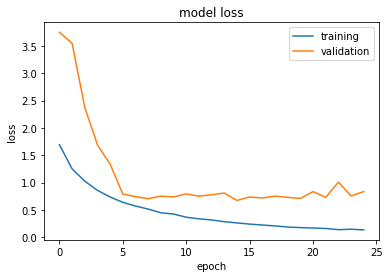

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

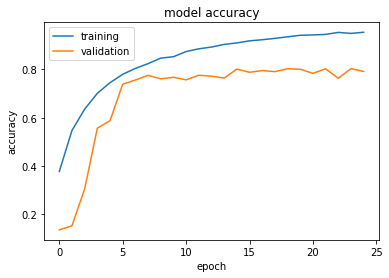

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

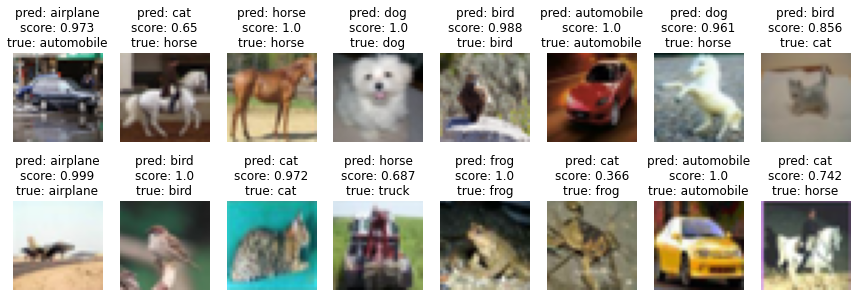

In [18]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# **Interpretations/ Conclusion**

**Results + Confusion Matrix interpretation**

The best overall Testing Accuracy reached by me this week is 81.10%. The confusion Matrix shows that airplanes, automobiles, frogs, horses, ships, and trucks were recognized very accuratly, while dogs were sometimes confused with cats and the other way round. Deers are sometimes confused with horses, but horses barely ever with deers. Birds sometimes get confused with different other animals.

**What I have learned**

Machine Learning is confusing, there are so many factors that influence the output, and even if one can make an educated guess, its taking forever to find an optimal configuration. But if the testing accuracy improves by even half a percentage it feels like its worth it. Also, its pretty impressive that what we can do with machine learning

**Suggestions for further research**

One could experiment with more activation functions. Or maybe dont do the early stopping once, to see whether the accuracy would actually improve at for example 1000 epochs.

**Conclusion**

Through systematic experimentation and educated guesses a Test Accuracy of 81.10% was reached. This is by far not a perfect accuracy, but a significant improvement from the first attempts with an testing accuracy only slightly above 50%.


# **Tips to Improve**

**Some tips on how to improve:**

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


